In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ..

/Share/home/shibinbin/projects/Deepfold2


In [13]:
import seaborn as sns
sns.set()

/dev/shm/shibinbin/anaconda2/lib/python2.7/site-packages/numexpr/cpuinfo.py:42: UserWarning: [Errno 2] No such file or directory
  warnings.warn(str(e), UserWarning, stacklevel=stacklevel)


In [15]:
import sys
sys.path.append('bin')

In [22]:
# read icSHAPE output as array
def read_icshape(filename):
    with open(filename, 'r') as f:
        reactivities = {}
        lengths = {}
        rpkms = {}
        for line in f:
            c = line.strip().split('\t')
            a = np.asarray(c[3:], dtype='S')
            a[a == 'NULL'] = 'nan'
            a = a.astype(np.float32)
            reactivities[c[0]] = a
            lengths[c[0]] = int(c[1])
            rpkms[c[0]] = float(c[2])
    return reactivities, lengths, rpkms
reactivities, lengths, rpkms = read_icshape('output/icSHAPE/reactivities/Lu_2016_invivo.human_known_rnas/icshape.out')

In [87]:
from formats import read_ct
names = {}
sequences = {}
structures = {}
for seq_name in reactivities.keys():
    names[seq_name], sequences[seq_name], structures[seq_name] = read_ct('data/human_known_rnas/%s.ct'%seq_name)
    structures[seq_name] = (np.asarray(structures[seq_name]) > 0).astype(np.int32)

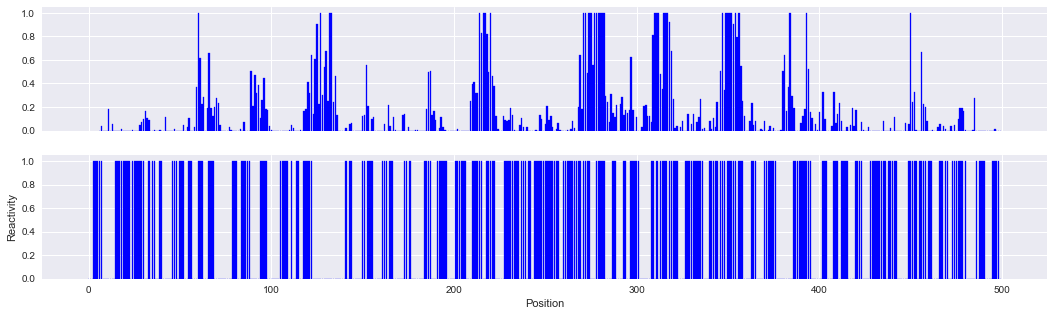

In [88]:
seq_name = 'human_SST'
max_length = min(500, lengths[seq_name])
fig, axes = plt.subplots(2, 1, figsize=(18, 5), sharex=True)
axes[0].bar(np.arange(max_length)[:max_length], reactivities[seq_name][:max_length], 
            edgecolor='b', color='b')
axes[1].bar(np.arange(max_length), np.clip(np.asarray(structures[seq_name]), 0, 1)[:max_length],
            edgecolor='b', color='b')
axes[1].set_xlabel('Position')
axes[1].set_ylabel('Reactivity')

In [141]:
canonical_names = {'human_SST': '18S rRNA', 'human_SRP': 'SRP', 'human_RMRP': 'RMRP'}

In [33]:
from sklearn.metrics import roc_auc_score

In [36]:
y_pred = reactivities[seq_name]
y_true = (np.asarray(structures[seq_name]) > 0).astype(np.int32)
print roc_auc_score(y_true[~np.isnan(y_pred)], y_pred[~np.isnan(y_pred)])

0.540382380443


In [18]:
from formats import read_ct
name, sequence, structure = read_ct('data/human_known_rnas/18S.ct')

In [149]:
from genomic_data import GenomicData
dataset = 'Lu_2016_invitro'
target = GenomicData('output/icSHAPE/reactivities/%s.human_known_rnas/target.rt.h5'%dataset)
background = GenomicData('output/icSHAPE/reactivities/Lu_2016_DMSO.human_known_rnas/target.rt.h5')
target_normalized = GenomicData('output/icSHAPE/reactivities/%s.human_known_rnas/target.normalized.rt.h5'%dataset)
background_normalized = GenomicData('output/icSHAPE/reactivities/Lu_2016_DMSO.human_known_rnas/target.normalized.rt.h5')

background_bd = {}
background_rt = {}
target_bd = {}
target_rt = {}
for name in target.names:
    background_bd[name] = background_normalized.feature('base_density', name).copy()
    background_rt[name] = background_normalized.feature('rt_stop', name).copy()
    target_bd[name] = target_normalized.feature('base_density', name).copy()
    target_rt[name] = target_normalized.feature('rt_stop', name).copy()

In [74]:
# new normalize method
normalized_reactivities = {}
for name in reactivities.keys():
    normalized_reactivities[name] = (target_rt[name] - background_rt[name])/background_bd[name]
    normalized_reactivities[name] = np.clip(normalized_reactivities[name], -2, 2)

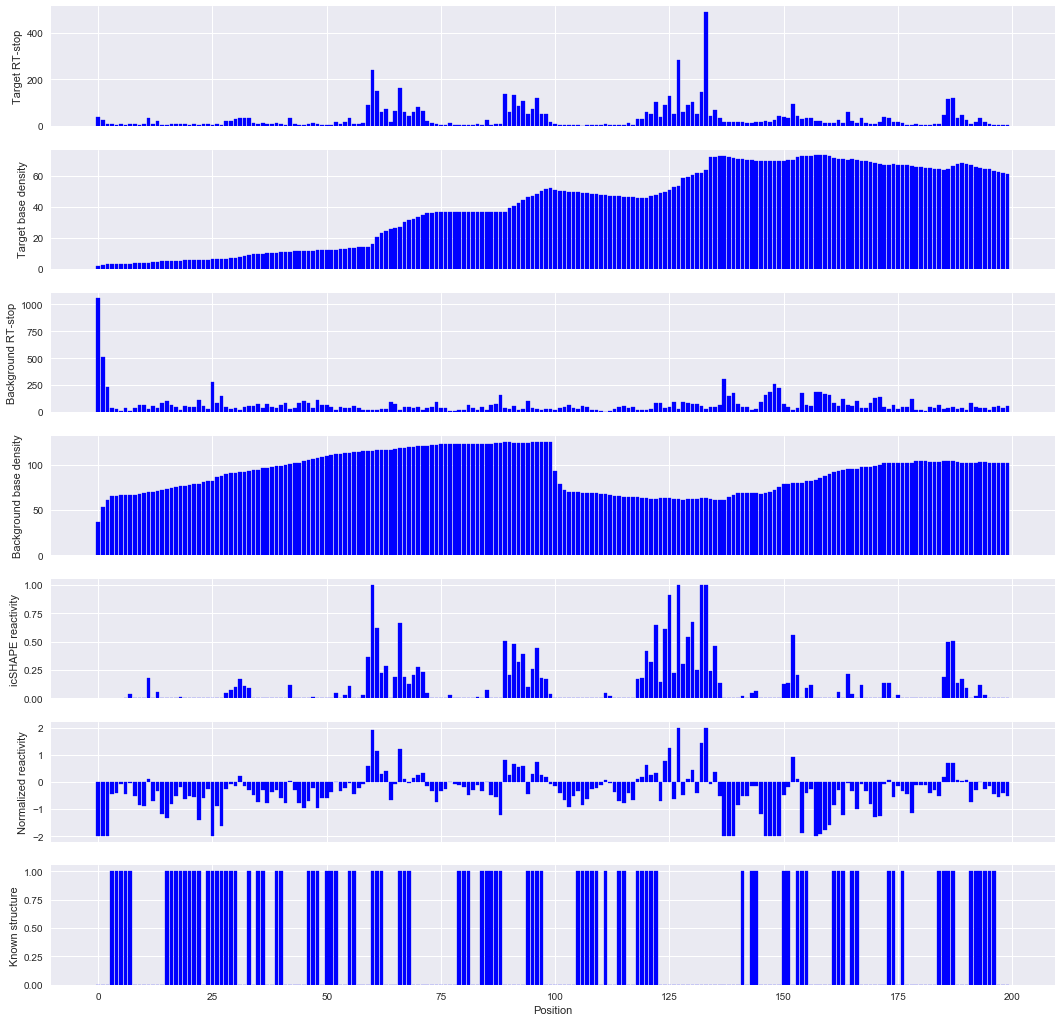

In [75]:
seq_name = 'human_SST'
start = 0
end = min(200, lengths[seq_name])
fig, axes = plt.subplots(7, 1, figsize=(18, 18), sharex=True)
x = np.arange(end - start)
axes[0].bar(x, target_rt[seq_name][start:end], edgecolor='b', color='b')
axes[0].set_ylabel('Target RT-stop')
axes[1].bar(x, target_bd[seq_name][start:end], edgecolor='b', color='b')
axes[1].set_ylabel('Target base density')
axes[2].bar(x, background_rt[seq_name][start:end], edgecolor='b', color='b')
axes[2].set_ylabel('Background RT-stop')
axes[3].bar(x, background_bd[seq_name][start:end], edgecolor='b', color='b')
axes[3].set_ylabel('Background base density')
axes[4].bar(x, reactivities[seq_name][start:end], edgecolor='b', color='b')
axes[4].set_ylabel('icSHAPE reactivity')
axes[5].bar(x, normalized_reactivities[seq_name][start:end], edgecolor='b', color='b')
axes[5].set_ylabel('Normalized reactivity')
axes[6].bar(x, structures[seq_name][start:end], edgecolor='b', color='b')
axes[6].set_ylabel('Known structure')
axes[6].set_xlabel('Position')

(2432, 2432, 2432, 2432)
(nan, 1.0)


/dev/shm/shibinbin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


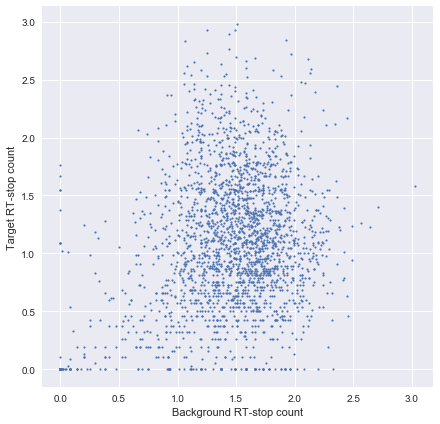

In [85]:
from scipy.stats import pearsonr

common_names = ['human_SST', 'human_RMRP', 'human_SRP']
background_bd_concat = np.concatenate([background_bd[name] for name in common_names])
background_rt_concat = np.concatenate([background_rt[name] for name in common_names])
target_bd_concat = np.concatenate([target_bd[name] for name in common_names])
target_rt_concat = np.concatenate([target_rt[name] for name in common_names])
print(background_bd_concat.shape[0], background_rt_concat.shape[0], 
      target_bd_concat.shape[0], target_rt_concat.shape[0])

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(np.log10(background_rt_concat + 1), np.log10(target_rt_concat + 1), s=3)
ax.set_xlabel('Background RT-stop count')
ax.set_ylabel('Target RT-stop count')
#ax.scatter(background_rt_concat, target_rt_concat, s=3)
print pearsonr(np.log10(background_rt_concat), np.log10(target_rt_concat))

In [146]:
from sklearn.metrics import roc_auc_score, roc_curve
roc_auc_scores = {}
roc_curves = {}
for seq_name in reactivities.keys():
    notnan_mask = ~np.isnan(reactivities[seq_name])
    roc_auc_scores[seq_name] = roc_auc_score(structures[seq_name][notnan_mask],
                                      reactivities[seq_name][notnan_mask])
    roc_curves[seq_name] = roc_curve(structures[seq_name][notnan_mask],
                                     reactivities[seq_name][notnan_mask])
print roc_auc

{'human_SRP': 0.48667711598746077, 'human_SST': 0.5403823804426876, 'human_RMRP': 0.51561946902654876}


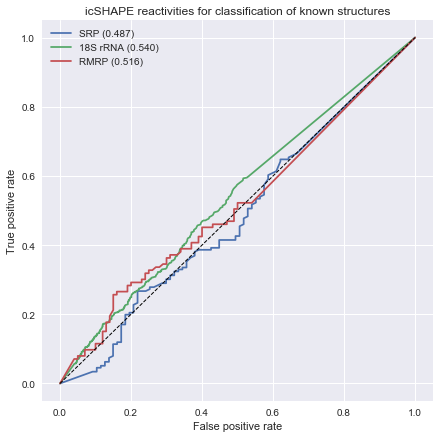

In [147]:
fig, ax = plt.subplots(figsize=(7, 7))
for seq_name in roc_curves:
    fpr, tpr, thresholds = roc_curves[seq_name]
    ax.plot(fpr, tpr, label='%s (%.3f)'%(canonical_names[seq_name], roc_auc_scores[seq_name]))
ax.plot([0, 1], [0, 1], linestyle='dashed', color='k', linewidth=1)
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('icSHAPE reactivities for classification of known structures')
plt.legend()

In [139]:
canonical_names = {'human_SST': '18S rRNA', 'human_SRP': 'SRP', 'human_RMRP': 'RMRP'}

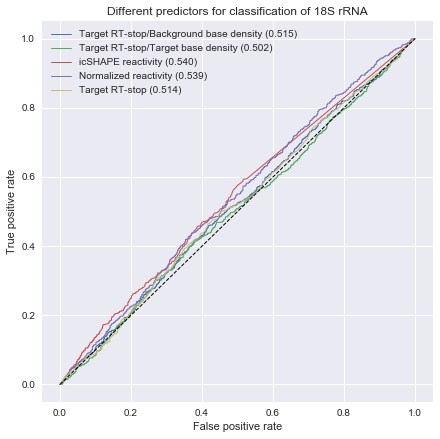

In [150]:
seq_name = 'human_SST'
# different types of predictors
predictors = {}
predictors['Target RT-stop'] = target_rt[seq_name]
predictors['Target RT-stop/Target base density'] = target_rt[seq_name]/target_bd[seq_name]
predictors['Target RT-stop/Background base density'] = target_rt[seq_name]/background_bd[seq_name]
predictors['icSHAPE reactivity'] = reactivities[seq_name]
predictors['Normalized reactivity'] = (target_rt[seq_name] - background_rt[seq_name])/background_bd[seq_name]

fig, ax = plt.subplots(figsize=(7, 7))
for predictor_name in predictors:
    notnan_mask = ~np.isnan(predictors[predictor_name])
    fpr, tpr, thresholds = roc_curve(structures[seq_name][notnan_mask],
                                     predictors[predictor_name][notnan_mask])
    auc = roc_auc_score(structures[seq_name][notnan_mask],
                        predictors[predictor_name][notnan_mask])
    ax.plot(fpr, tpr, label='%s (%.3f)'%(predictor_name, auc), linewidth=1)

ax.plot([0, 1], [0, 1], linestyle='dashed', color='k', linewidth=1)
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('Different predictors for classification of %s'%canonical_names[seq_name])
plt.legend()

In [111]:
ax.plot?

In [104]:
len(roc_curves['human_SST'])

3

In [90]:
structures

{'human_RMRP': array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], dtype=int32),
 'human_SRP': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,

In [94]:
np.savetxt('tmp/human_SRP.Lu_2016_invivo.txt', np.nan_to_num(reactivities['human_SRP']), fmt='%f')

In [93]:
np.savetxt?